In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import h5py
import math
import scipy
import torch
import pdb
import utils
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models

In [2]:
os.sys.path

['',
 '/home/ubuntu/src/cntk/bindings/python',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [3]:
home = os.path.expanduser("~")
dataRoot = os.path.join(home, "CS230", "CheXpert-v1.0-small")
os.listdir(dataRoot)

['valid',
 'valid_final.csv',
 'train_final.csv',
 'train_final_V2.csv',
 'train_1_example.csv',
 'train',
 'valid.csv',
 'test_final.csv',
 'train.csv',
 'valid_1_example.csv']

In [4]:
"""Import and Preprocess Data"""

'Import and Preprocess Data'

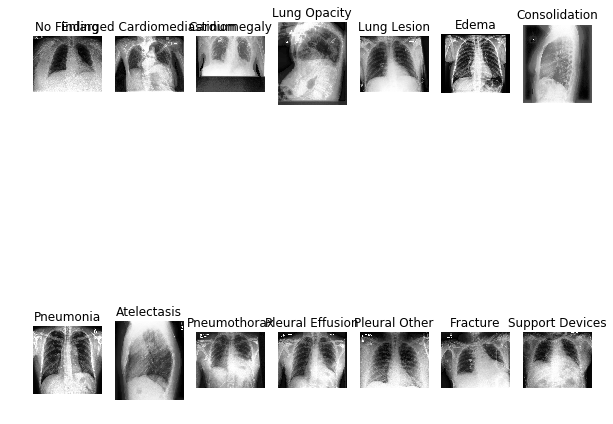

In [5]:
import cv2

TASKS = ['No Finding', 'Enlarged Cardiomediastinum', 
         'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 
         'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
        'Fracture', 'Support Devices']

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(2, 7, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:14], labels[:14]):
        if method == 'cv2':
            img = cv2.imread('/home/ubuntu/CS230/' + path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

from torch.nn import functional as F

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

df = pd.read_csv('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv')
paths = df['Path'][:14]
labels = df[TASKS][:14]

view_dataset(paths, labels)

In [6]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, data_split, toy=False):
     
        df = pd.read_csv(data_split)
        
        # Remove any paths for which the image files do not exist
        #df = df[df["Path"].apply(os.path.exists)]
      
        #print ("%s size %d" % (data_split, df.shape[0]))

        #Could remove
        if toy:
            df = df.sample(frac=0.05)

        self.img_paths = df["Path"].apply(lambda x: '/home/ubuntu/CS230/' + x)
        self.labels = df[TASKS]
        self.n_classes = len(self.labels)
        self.transforms = transforms.Compose([
                            transforms.CenterCrop((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                        ])
                    
    def __getitem__(self, index):
        img = Image.open(self.img_paths.iloc[index]).convert("RGB")
        img = self.transforms(img)
        label = self.labels.iloc[index]
        label = np.nan_to_num(label)
        label[label < 0] = 0
        label_vec = torch.FloatTensor(label).cuda()
        #print(img)
        return img, label_vec
          

    def __len__(self):
        return len(self.img_paths)

In [7]:
train_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv',toy=False)
test_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/valid_final.csv',toy=False)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

print(len(train_loader))
print(len(test_loader))
print(train_loader)

12500
73


In [8]:
#Define Model

In [9]:
# '''ResNet in PyTorch.
# For Pre-activation ResNet, see 'preact_resnet.py'.
# Reference:
# [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
#     Deep Residual Learning for Image Recognition. arXiv:1512.03385
# '''
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(self.expansion*planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=14):
#         super(ResNet, self).__init__()
#         self.in_planes = 224

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.linear = nn.Linear(512*block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = F.avg_pool2d(out, 4)
#         out = out.view(out.size(0), -1)
#         out = self.linear(out)
#         return out


# def ResNet18():
#     return ResNet(BasicBlock, [2,2,2,2])

# def ResNet34():
#     return ResNet(BasicBlock, [3,4,6,3])

# def ResNet50():
#     return ResNet(Bottleneck, [3,4,6,3])

# def ResNet101():
#     return ResNet(Bottleneck, [3,4,23,3])

# def ResNet152():
#     return ResNet(Bottleneck, [3,8,36,3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1,3,32,32))
#     print(y.size())

# # test()

In [10]:
import torchvision.models as models
model = models.resnet18(pretrained=True).cuda()
model.fc = torch.nn.Linear(512, 14).cuda()
#model.train()

In [11]:
#densenet = models.densenet161(pretrained=True)

In [12]:
import torch.optim as optim

# Define the cost function
criterion = nn.BCEWithLogitsLoss().cuda()

# Define the optimizer, learning rate 
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr)

In [13]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

Epoch:0, Iteration: 0, training cost = 0.4669511914253235, Recall score =0.75, F1 score =0.6666666666666665
Epoch:0, Iteration: 100, training cost = 0.47487199306488037, Recall score =0.36363636363636365, F1 score =0.4210526315789474
Epoch:0, Iteration: 200, training cost = 0.5151817202568054, Recall score =0.15384615384615385, F1 score =0.21052631578947367
Epoch:0, Iteration: 300, training cost = 0.40200015902519226, Recall score =0.36363636363636365, F1 score =0.4705882352941177
Epoch:0, Iteration: 400, training cost = 0.36370837688446045, Recall score =0.36363636363636365, F1 score =0.4705882352941177
Epoch:0, Iteration: 500, training cost = 0.37747201323509216, Recall score =0.3333333333333333, F1 score =0.42857142857142855
Epoch:0, Iteration: 600, training cost = 0.30236324667930603, Recall score =0.2222222222222222, F1 score =0.3636363636363636
Epoch:0, Iteration: 700, training cost = 0.3705006539821625, Recall score =0.4, F1 score =0.5714285714285715
Epoch:0, Iteration: 800, tra

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch:0, Iteration: 1400, training cost = 0.31631800532341003, Recall score =0.2727272727272727, F1 score =0.42857142857142855
Epoch:0, Iteration: 1500, training cost = 0.35244590044021606, Recall score =0.16666666666666666, F1 score =0.26666666666666666
Epoch:0, Iteration: 1600, training cost = 0.36993417143821716, Recall score =0.0, F1 score =0.0
Epoch:0, Iteration: 1700, training cost = 0.2495131939649582, Recall score =0.4, F1 score =0.5714285714285715
Epoch:0, Iteration: 1800, training cost = 0.4196122884750366, Recall score =0.125, F1 score =0.16666666666666666
Epoch:0, Iteration: 1900, training cost = 0.24980653822422028, Recall score =0.375, F1 score =0.4615384615384615
Epoch:0, Iteration: 2000, training cost = 0.3601706922054291, Recall score =0.0, F1 score =0.0
Epoch:0, Iteration: 2100, training cost = 0.38713178038597107, Recall score =0.2, F1 score =0.28571428571428575
Epoch:0, Iteration: 2200, training cost = 0.40139663219451904, Recall score =0.2857142857142857, F1 score 

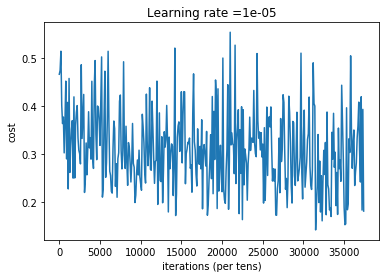

Average recall =0.39538290186031827
Average recall =0.39538290186031827


In [30]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Train Network
total_step = len(train_loader)
epoch_list = []
loss_list = []
acc_list = []
total_recall = []
f1_total = []


best_val_acc = 0.0

for epoch in range(3):
    #logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward propogation
        outputs = model(inputs)
 
        outputs = outputs.cuda()
        
        # calculate the loss
        loss = criterion(outputs, labels)
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        state = {'epoch': epoch + 1,
         'state_dict': model.state_dict(),
         'optim_dict' : optimizer.state_dict()}
        
        torch.save(model.state_dict(), '/home/ubuntu/CS230/CS230-Project/Model/result_resnet.pt')

        
#         utils.save_checkpoint({'epoch': epoch + 1,
#                                'state_dict': model.state_dict(),
#                                'optim_dict' : optimizer.state_dict()},
#                                is_best=is_best,
#                                checkpoint=model_dir)
        
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy() 
        
        recall = recall_score(labels,outputs, average = 'micro')
        total_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_total.append(f1)

        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost) + ", Recall score =" + str(recall) 
                  + ", F1 score =" + str(f1))
            loss_list.append(cost)
            epoch_list.append(epoch*12500 + i)

plt.plot(epoch_list,loss_list)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(lr))
plt.show()

print("Average recall =" + str(sum(total_recall)/len(total_recall)))
print("Average F1 score is: ",sum(f1_test)/len(f1_test))

In [16]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from torch.autograd import Variable

def test():
    model = models.resnet18(pretrained=True).cuda()
    model.fc = torch.nn.Linear(512, 14).cuda()
    model.load_state_dict(torch.load('/home/ubuntu/CS230/CS230-Project/Model/result_resnet.pt'))
    test_recall = []
    f1_test = []
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy()
        
        #test_acc += torch.sum(prediction == labels.data)
        
        recall = recall_score(labels,outputs, average = 'micro')
        test_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_test.append(f1)

    # Compute the average acc and loss over all 10000 test images
    #test_acc = test_acc / 10000
    
    print("Average recall =" + str(sum(test_recall)/len(test_recall)))
    print("Average F1 score is: ",sum(f1_test)/len(f1_test))

    return test_acc

In [17]:
test()

Average recall =0.4003704013776535
Average F1 score is:  0.46905173952482976


0.0